In [32]:
include("Spreader.jl")

Main.Spreader

In [33]:
using CSV
using DataFrames
using RollingFunctions
using StatsBase
using ShiftedArrays
using PairPlots
using CairoMakie
using StatsPlots
using Chain
using Query
using .Spreader
using Colors
using ColorSchemes
gr()

Plots.GRBackend()

In [123]:
WORKERS = 131_100_000

131100000

In [124]:
df = DataFrame(CSV.File("Adult.csv", missingstring="?"))
println("Number of rows: " * string(nrow(df)))

Number of rows: 48842


In [125]:
total_weight = sum(df[:,:fnlwgt])

9263575662

In [126]:
weight_factor = WORKERS/total_weight

0.014152202646520576

In [127]:
spread!(df,"workclass")
spread!(df,"education")
spread!(df,"marital_status")
spread!(df,"occupation")
spread!(df,"race")
spread!(df,"sex")
spread!(df,"native_country")
spread!(df,"class")
println("Number of columns after spread operations: " * string(ncol(df)))

Number of columns after spread operations: 109


In [128]:
function zero(dummy)
    return 0
end
df[!,Between(:Private,end)] = df[!,Between(:Private,end)] .* (df[!,:fnlwgt] * weight_factor)
df[!,Between(:Private,end)] = Int64.(round.(df[!,Between(:Private,end)]));
transform!(df, :fnlwgt => zero => :Total)
df[!,:Total] = df[!,:Total] = (df[!,:fnlwgt] * weight_factor)
df[!,:Total] = Int64.(round.(df[!,:Total]));

In [129]:
df[:,Between(:Private,end)]

Row,Private,Local_gov,Self_emp_not_inc,Federal_gov,State_gov,Self_emp_inc,Without_pay,11th,HS_grad,Assoc_acdm,Some_college,10th,Prof_school,7th_8th,Bachelors,Masters,5th_6th,Assoc_voc,9th,Doctorate,12th,1st_4th,Preschool,Never_married,Married_civ_spouse,Widowed,Separated,Divorced,Married_spouse_absent,Married_AF_spouse,Machine_op_inspct,Farming_fishing,Protective_serv,Other_service,Prof_specialty,Craft_repair,Adm_clerical,Exec_managerial,Tech_support,Sales,Priv_house_serv,Transport_moving,Handlers_cleaners,Armed_Forces,Black,White,Other,Amer_Indian_Eskimo,Asian_Pac_Islander,Male,Female,United_States,Peru,Guatemala,Mexico,Dominican_Republic,Ireland,Germany,Philippines,Thailand,Haiti,El_Salvador,Puerto_Rico,Vietnam,South,Columbia,Japan,India,Cambodia,Poland,Laos,England,Cuba,Taiwan,Italy,Canada,Portugal,China,Nicaragua,Honduras,Iran,Scotland,Jamaica,Ecuador,Yugoslavia,Hungary,Hong,Greece,Trinadad&Tobago,Outlying_US(Guam_USVI_etc),France,Holand_Netherlands,<=50K,>50K,Total
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,3210,0,0,0,0,0,0,3210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3210,0,0,0,0,0,0,3210,0,0,0,0,0,0,0,0,0,0,0,0,0,3210,0,0,0,0,3210,0,3210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3210,0,3210
2,1271,0,0,0,0,0,0,0,1271,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1271,0,0,0,0,0,0,1271,0,0,0,0,0,0,0,0,0,0,0,0,0,1271,0,0,0,1271,0,1271,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1271,0,1271
3,0,4769,0,0,0,0,0,0,0,4769,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4769,0,0,0,0,0,0,0,4769,0,0,0,0,0,0,0,0,0,0,0,0,4769,0,0,0,4769,0,4769,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4769,4769
4,2269,0,0,0,0,0,0,0,0,0,2269,0,0,0,0,0,0,0,0,0,0,0,0,0,2269,0,0,0,0,0,2269,0,0,0,0,0,0,0,0,0,0,0,0,0,2269,0,0,0,0,2269,0,2269,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2269,2269
5,0,0,0,0,0,0,0,0,0,0,1465,0,0,0,0,0,0,0,0,0,0,0,0,1465,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1465,0,0,0,0,1465,1465,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1465,0,1465
6,2812,0,0,0,0,0,0,0,0,0,0,2812,0,0,0,0,0,0,0,0,0,0,0,2812,0,0,0,0,0,0,0,0,0,2812,0,0,0,0,0,0,0,0,0,0,0,2812,0,0,0,2812,0,2812,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2812,0,2812
7,0,0,0,0,0,0,0,0,3213,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3213,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3213,0,0,0,0,3213,0,3213,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3213,0,3213
8,0,0,1481,0,0,0,0,0,0,0,0,0,1481,0,0,0,0,0,0,0,0,0,0,0,1481,0,0,0,0,0,0,0,0,0,1481,0,0,0,0,0,0,0,0,0,0,1481,0,0,0,1481,0,1481,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1481,1481
9,5232,0,0,0,0,0,0,0,0,0,5232,0,0,0,0,0,0,0,0,0,0,0,0,5232,0,0,0,0,0,0,0,0,0,5232,0,0,0,0,0,0,0,0,0,0,0,5232,0,0,0,0,5232,5232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5232,0,5232


In [130]:
CSV.write("adult_spread.csv",df)

"adult_spread.csv"

In [131]:
gdf = groupby(df,:sex)
combine(gdf, :Private => sum)

Row,sex,Private_sum
,String7,Int64
1,Male,61700910
2,Female,30750448


In [132]:
gdf = groupby(df,:education)
combine(gdf, :Private => sum);

In [133]:
gdf = groupby(df,[:education])
comb = combine(gdf) do sdf
    DataFrame(State_gov  = sum(sdf.State_gov))
end;

In [134]:
cs1 = ColorScheme((reverse(Colors.sequential_palette(300, 100, logscale=true)))[1:5:80])
colors = [RGBA(cs1[i]) for i in 1:size(cs1)];

Proportion of Education Levels of Privatly Employed Individuals


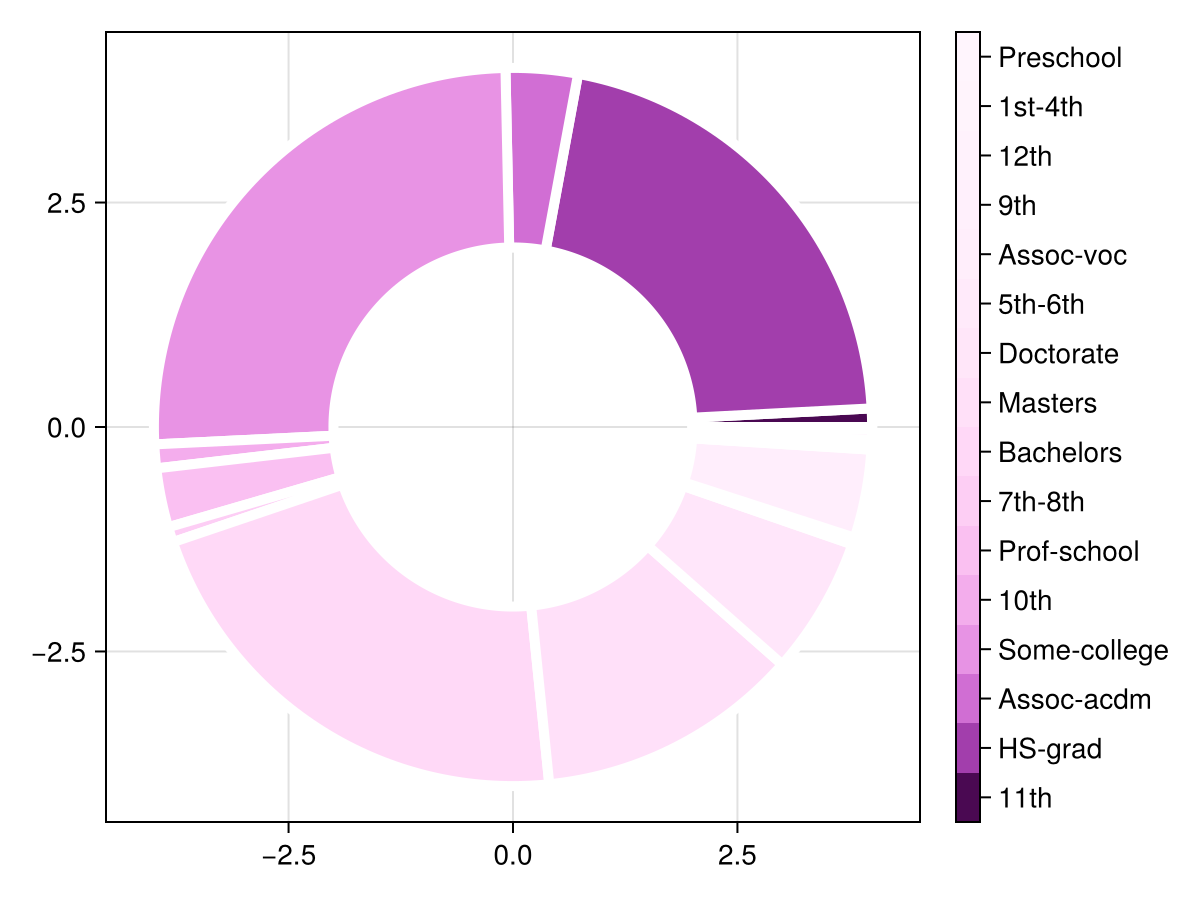

In [135]:
data = [comb[i,:State_gov] for i in 1:size(comb,1)]
category = [comb[i,:education] for i in 1:size(comb,1)]

nc = length(colors)
nδ = 1/nc

f, ax, plt = CairoMakie.pie(data,
                 radius = 4,
                 color = colors, 
                 inner_radius = 2,
                 strokecolor = :white,
                 strokewidth = 5,
                 axis = (autolimitaspect = 1, )
                )

cbar = Colorbar(f[1,2], colormap = cgrad(colors, categorical = true))
cbar.ticks = (range(0+nδ/2, 1-nδ/2, nc), string.(category))

println("Proportion of Education Levels of Privatly Employed Individuals")
f